In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from joblib import Parallel, delayed
import multiprocessing
import pickle as pckl
import matplotlib.animation as animation
import progressbar
from scipy.signal import argrelextrema
from scipy.cluster.vq import kmeans, vq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from tqdm import tqdm


# Functions

#### integration functions

In [2]:
# define the right hand side of the FHN system 
# 1D, periodic BC
def fhn(phi, epsilon = 0.01, alpha = 0.1, dx=1.):
    u = phi[0]
    v = phi[1]

    grad2_u = []
    grad2_u.append((u[1]+u[-1]-2*u[0])/dx**2)
    for i in range(1,len(u)-1):
            grad2_u.append((u[(i+1)]+u[(i-1)]-2*u[i])/dx**2)
    grad2_u.append((u[-2]+u[0]-2*u[-1])/dx**2)
    grad2_u = np.array(grad2_u)
    
    grad2_v = []
    grad2_v.append((v[1]+v[-1]-2*v[0])/dx**2)
    for i in range(1,len(v)-1):
            grad2_v.append((v[(i+1)]+v[(i-1)]-2*v[i])/dx**2)
    grad2_v.append((v[-2]+v[0]-2*v[-1])/dx**2)
    grad2_v = np.array(grad2_v)

    new_u =   grad2_u + u - u**3 - v
    new_v =   epsilon*(grad2_v +  u - alpha*v) 
    
    new_phi = np.array([new_u, new_v])
    return new_phi


# Runge-Kutta 4
def rk4(phi0, dt, epsilon, alpha, dx):
    k1 = dt * fhn(phi0, epsilon, alpha, dx)
    k2 = dt * fhn(phi0+k1/2., epsilon, alpha, dx)
    k3 = dt * fhn(phi0+k2/2., epsilon, alpha, dx)
    k4 = dt * fhn(phi0+k3, epsilon, alpha, dx)
    k = (k1+2*k2+2*k3+k4)/6.
    return phi0 + k

In [9]:
# integration of the FHN system with epsilon varying in time 
def evolve_phi(phi0, Nt, dt, Nx, dx, epsilon, alpha, noise_amplitude):
    phi = phi0.copy()   
    PHI = np.empty((2, Nx, Nt)) 
    
    # evolve
    for t in tqdm(range(Nt)):
        # store current phi version
        PHI[:,:, t] = phi.copy()
        # update phi
        phi = rk4(phi, dt, epsilon, alpha, dx)
        # add noise
        noise = np.random.normal(0.0, 1, (2,Nx))
        noise[1,:] = epsilon*noise[1,:]
        phi += noise_amplitude*noise
        # choose a new epsilon value after each complete oscillation of the system
        if t > 1:
            mu_0 = np.mean(PHI[0,:,t-1])  
            mu = np.mean(PHI[0,:,t])
            if (mu_0 < 0) & (mu >= 0):
                # epsilon chosen randomly
                epsilon = np.random.uniform(0.001, 0.033)    
    return PHI

#### network construction functions

In [4]:
def gamma_loop(rho2, Nx, num_segments, gamma):
    # rho2 -- list of correlation matrices, definning the time-evolving network 
    # Nx -- number of spatial points (network nodes)
    # num_segments -- number of correlation matrices / of time steps in the evolution of the network 
    # gamma -- correlation threshold for the network construction
    
    S1_line = np.zeros(num_segments) # size of the largest connected component in the time-evolving network
    av_s_line = np.zeros(num_segments) # average size of remaining components (ie excluding S1) 
    c2_line = np.zeros(num_segments) # probability that a randomly chosen node belongs to a component of size 2
    
    for time_step in range(num_segments):
        G=nx.Graph()
        G.add_nodes_from(list(range(Nx)))
        # create edge list
        edge_list = []
        indices = np.where(rho2[time_step] > gamma)
        edge_list= zip(indices[0],indices[1])
        # append edges to graph
        G.add_edges_from(edge_list)
        # largest connected component
        lcc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
        S1_line[time_step] = lcc[0]/Nx
        # average size of smaller components
        sizes, counts = np.unique(lcc[1:], return_counts = True)
        av_s_line[time_step] = np.sum(sizes**2*counts)
        # probability that a node belongs to a cluster of given size s
        cs = sizes*counts/Nx
        if 2 in sizes:
            c2_line[time_step]=cs[sizes == 2]

    return [gamma, S1_line, av_s_line, c2_line]

# Integragion

In [32]:
# create a folder for the new experiment
folder_name = "./scenario_test"

try:
    os.mkdir(folder_name)
except OSError:
    raise OSError("The directory already exists.")
else:
    print ("Successfully created the directory %s " % folder_name)

# model parameters
epsilon = 0.01
alpha = -0.83
# noise
C=0.01 

# define the model and simulation parameters
T = 800.
Nt =16000
dt = T/Nt
L = 500.
Nx = 500
dx = L/Nx


# store the parameters in a text file
Parameters = {"T": T, "Nt": Nt, "dt": dt, "L": L, "Nx": Nx, "dx": dx, "epsilon": epsilon, "alpha": alpha, "C": C, "D": 1}
print("Summary:")    
print("Simulation parameters -- L=", Parameters["L"], ", dx=", Parameters["dx"], ", Nx=", Parameters["Nx"], "T=", Parameters["T"], ", dt=", Parameters["dt"], ", Nt=", Parameters["Nt"])
print("Model parameters -- epsilon=", Parameters["epsilon"], ", alpha=", Parameters["alpha"], ", C=", Parameters["C"], ", D=",Parameters["D"])
    
with open(folder_name +'/params.txt', 'w') as f:
    for key, value in Parameters.items(): 
        f.write('%s:%s\n' % (key, value))
        f.write('\n')
        
        
        
### EVOLVE PHI ###
noise_amplitude = np.sqrt(2.*C*dt/dx) # noise amplitude
phi0 = np.array([0.0*np.random.normal(0.0, 1., Nx)-0.16, 0.0*np.random.normal(0.0, 1., Nx)+0.01]) # intial condition
PHI = evolve_phi(phi0, Nt, dt, Nx, dx, epsilon, alpha, noise_amplitude) 
u = PHI[0,:,:] # matrix for u of size (num_x, num_time_step)
v = PHI[1,:,:]
tt_PHI = (np.array(range(Nt)))*dt  # time axis associated with the values in PHI


### SAVE PHI ###
filename = folder_name+'/PHI.pckl'
outfile = open(filename,'wb')
pckl.dump(PHI,outfile)
outfile.close()

  0%|          | 7/16000 [00:00<03:51, 69.11it/s]

Successfully created the directory ./scenario_test 
Summary:
Simulation parameters -- L= 500.0 , dx= 1.0 , Nx= 500 T= 800.0 , dt= 0.05 , Nt= 16000
Model parameters -- epsilon= 0.01 , alpha= -0.83 , C= 0.01 , D= 1


100%|██████████| 16000/16000 [02:51<00:00, 93.36it/s]


# Figure

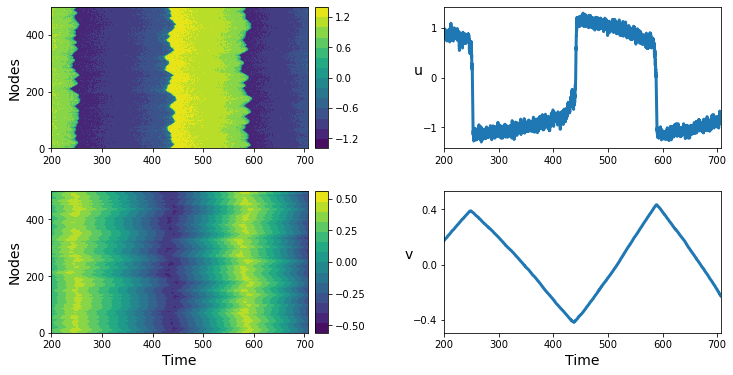

In [33]:
# sub-period of the complete time series for plotting and analysis
init_i = 4000
final_i = 14000+140


## Plot evolution
fig = plt.figure(figsize = (12,6))
gs = GridSpec(2, 2, figure=fig)

## create sub plots as grid
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])

divider11 = make_axes_locatable(ax11)
divider21 = make_axes_locatable(ax21)

plt.subplots_adjust(wspace=0.42, hspace=0.3)
################ spatio-temporal evolution #########
yspace = np.array(range(Nx))
xt, ys = np.meshgrid(tt_PHI,yspace)

im1 = ax11.contourf(xt, ys, PHI[0,:,:],15)
cax1 = divider11.append_axes("right", size="5%", pad=0.1)
cb11 = fig.colorbar(im1, cax=cax1)
tick_locator = ticker.MaxNLocator(nbins=5)
cb11.locator = tick_locator
cb11.update_ticks()



ax11.set_ylabel('Nodes', fontsize=14)
ax11.set_xlim((init_i)*dt, dt*(final_i))
ax11.yaxis.set_major_locator(MaxNLocator(3)) 

im2 = ax21.contourf(xt, ys, PHI[1,:,:],15)
cax21 = divider21.append_axes("right", size="5%", pad=0.1)
cb21 = fig.colorbar(im2, cax=cax21)
tick_locator = ticker.MaxNLocator(nbins=5)
cb21.locator = tick_locator
cb21.update_ticks()




ax21.set_xlabel('Time', fontsize=14)
ax21.set_ylabel('Nodes', fontsize=14)
ax21.set_xlim((init_i)*dt, dt*(final_i))
ax21.yaxis.set_major_locator(MaxNLocator(3)) 

################ temporal evolution #########

ax12.plot(tt_PHI,PHI[0,20,:], label = 'u', linewidth=3, alpha = 1)

ax12.set_xlim((init_i)*dt, dt*(final_i))
ax12.set_ylabel('u', fontsize=14, rotation="horizontal")
ax12.yaxis.set_major_locator(MaxNLocator(3)) 

ax22.plot(tt_PHI,PHI[1,250,:], label = 'v', linewidth=3, alpha = 1)

ax22.set_xlim((init_i)*dt, dt*(final_i))
ax22.set_ylabel('v', fontsize=14, rotation="horizontal")
ax22.set_xlabel('Time', fontsize=14)
ax22.yaxis.set_major_locator(MaxNLocator(3)) 

################ save ################
plt.savefig(folder_name+"solution-FHN.png", dpi = 600 )

## Network and percolation measures 

In [34]:
subfolder = "/e1"

try:
    os.mkdir(folder_name+subfolder)
except OSError:
    raise OSError("The directory already exists.")
else:
    print ("Successfully created the directory %s " % subfolder)


# for the time-dependent network:
num_t = 140 # number of time steps per sub-sequence
step = 5 # number of time steps between consecutive sub-sequences
num_thresholds = 10 # number of correlation thresholds to test

Gammas_nd = np.linspace(0.6, 0.7, num_thresholds, endpoint=True) # set of correlation threshold(s) for the nework contruction with *non-detrended* data 
Gammas_d = np.linspace(0.48, 0.58, num_thresholds, endpoint=True) # set of correlation threshold(s) for the nework contruction with *detrended* data

# store the network parameters 
network_parameters = {"init_i": init_i, "final_i": final_i, "num_t": num_t, "step": step, "Gammas_nd": Gammas_nd, "Gammas_d": Gammas_d}
with open(folder_name+subfolder +'/net_params.txt', 'w') as f:
    for key, value in network_parameters.items(): 
        f.write('%s:%s\n' % (key, value))
        f.write('\n')

Successfully created the directory /e1 


### For the non-detrended data

In [35]:
###################################################################################
################## devide the time evolution in sub-sequences ##################### 

u_s = [PHI[0,:,i:i+num_t] for i in range(init_i,final_i,step)]
u_s = np.array(u_s, dtype = np.float16) # shape (num_segments, num_x, num_t)
Ns = u_s.shape[0] # number of sub-sequences


###################################################################################
########### compute correlation matrices for each of the Ns sub-sets ##############
print("Computing the correlation matrices")

# check if the correlation matrices have already been computed
if os.path.exists(folder_name+'/rho2.pckl'):
    # load rho  
    f = open(folder_name+'/rho2.pckl', 'rb')
    rho2 = pckl.load(f)
    f.close()
else:
    rho2 = [] # container for the correlation matrices    
    for time_step in tqdm(range(Ns)):
        rho2.append(pd.DataFrame(data=((u_s[time_step, :,:].real).transpose())).corr(method='pearson'))

    filename = folder_name+'/rho2.pckl'
    outfile = open(filename,'wb')
    pckl.dump(rho2,outfile)
    outfile.close()


    
###################################################################################
### inteprete the correlation matrices as networks and compute network measures ###
print('computing ', Ns, ' networks for each of the ', len(Gammas_nd), ' thresholds.')    
Result = Parallel(n_jobs=10)(delayed(gamma_loop)(rho2, Nx, Ns, gamma) for  gamma in tqdm(Gammas_nd))
measures_nd = pd.DataFrame(np.array(Result), columns=["Gamma", "S1", "av_s", "c2"])

###################################################################################
################################## store results ##################################

filename = folder_name+subfolder+'/measures_nd.pckl'
outfile = open(filename,'wb')
pckl.dump(measures_nd,outfile)
outfile.close()

  0%|          | 2/2028 [00:00<02:42, 12.47it/s]

Computing the correlation matrices


  0%|          | 0/10 [00:00<?, ?it/s]

computing  2028  networks for each of the  10  thresholds.


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


### For the detrended data

In [55]:
###################################################################################
############################# detrend time series #################################
if os.path.exists(folder_name+subfolder+'/smoothed_u.pckl'):
    # load rho  
    f = open(folder_name+subfolder+'/smoothed_u.pckl', 'rb')
    smoothed_u = pckl.load(f)
    f.close()
else:
    print("detrending data")
    bandwidth = 40
    smoothed_u = np.empty((Nx, Nt))
    for t in range(Nt):
        kernel = np.exp(-((np.array(range(Nt)) - t) ** 2) / (2 * (bandwidth ** 2)))
        kernel /= kernel.sum()
        smoothed_u[:,t] = np.sum(PHI[0,:,:]*kernel, axis=1)        
    ### store the detrended data
    filename = folder_name+subfolder+'/smoothed_u.pckl'
    outfile = open(filename,'wb')
    pckl.dump(smoothed_u,outfile)
    outfile.close()
    

###################################################################################
################## devide the time evolution in sub-sequences #####################

u_s = [PHI[0,:,i:i+num_t]- smoothed_u[:,i:i+num_t]  for i in range(init_i,final_i,step)] # devide the time evolution in sub-sequences 
u_s = np.array(u_s, dtype = np.float16) # shape (num_segments, num_x, num_t)
Ns = u_s.shape[0] # number of sub-sequences


###################################################################################
########### compute correlation matrices for each of the Ns sub-sets ##############
print("Computing the correlation matrices")

# check if the correlation matrices have already been computed
if os.path.exists(folder_name+'/rho2d.pckl'):
    # load rho  
    f = open(folder_name+'/rho2d.pckl', 'rb')
    rho2d = pckl.load(f)
    f.close()
else:
    rho2d = [] # container for the correlation matrices    
    for time_step in tqdm(range(Ns)):
        rho2d.append(pd.DataFrame(data=((u_s[time_step, :,:].real).transpose())).corr(method='pearson'))

    filename = folder_name+'/rho2d.pckl'
    outfile = open(filename,'wb')
    pckl.dump(rho2d,outfile)
    outfile.close()


    
###################################################################################
### inteprete the correlation matrices as networks and compute network measures ###
print('computing ', Ns, ' networks for each of the ', len(Gammas_d), ' thresholds.')    
Result = Parallel(n_jobs=10)(delayed(gamma_loop)(rho2d, Nx, Ns, gamma) for  gamma in tqdm(Gammas_d))
measures_d = pd.DataFrame(np.array(Result), columns=["Gamma", "S1", "av_s", "c2"])

###################################################################################
################################## store results ##################################

filename = folder_name+subfolder+'/measures_d.pckl'
outfile = open(filename,'wb')
pckl.dump(measures_d,outfile)
outfile.close()

Computing the correlation matrices


  0%|          | 0/10 [00:00<?, ?it/s]

computing  2028  networks for each of the  10  thresholds.


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


## Variance

In [37]:
# compute variabce
var_s = [np.var(PHI[0,:,i]) for i in range(Nt)] # devide the time evolution in sub-sequences  
var_s = np.array(var_s, dtype = np.float16) # shape (num_segments, num_x, num_t)

# Figures

In [38]:
# compute the spatial mean of PHI
PHI_mean = np.mean(PHI, axis = 1)

# define the time axis associated with the values in S1 and c2
tt_measures = (np.array(range(init_i, final_i, step))+num_t)*dt

### non-detrended data

In [46]:
# select the threshold value to plot time series for    
gidx_nd = 0
print("Chosen threshold for plotting the non-detrended data: ", measures_nd["Gamma"][gidx_nd])
gamma_str_nd = str(measures_nd["Gamma"][gidx_nd]) # string used in the figures legend
gamma_str_nd = gamma_str_nd.replace('.', 'p',1)

# time series of the percolation measures
S1 = measures_nd["S1"][gidx_nd]
c2 = measures_nd["c2"][gidx_nd]

# smooth the c2 curve for claritiy of the figure
bandwidth = 20
smoothed_c2 = []
for t in range(bandwidth, len(c2)-bandwidth+1):
    smoothed_c2.append(np.mean(c2[t-bandwidth:t+bandwidth]))
smoothed_c2 = np.array(smoothed_c2)


Chosen threshold for plotting the non-detrended data:  0.6


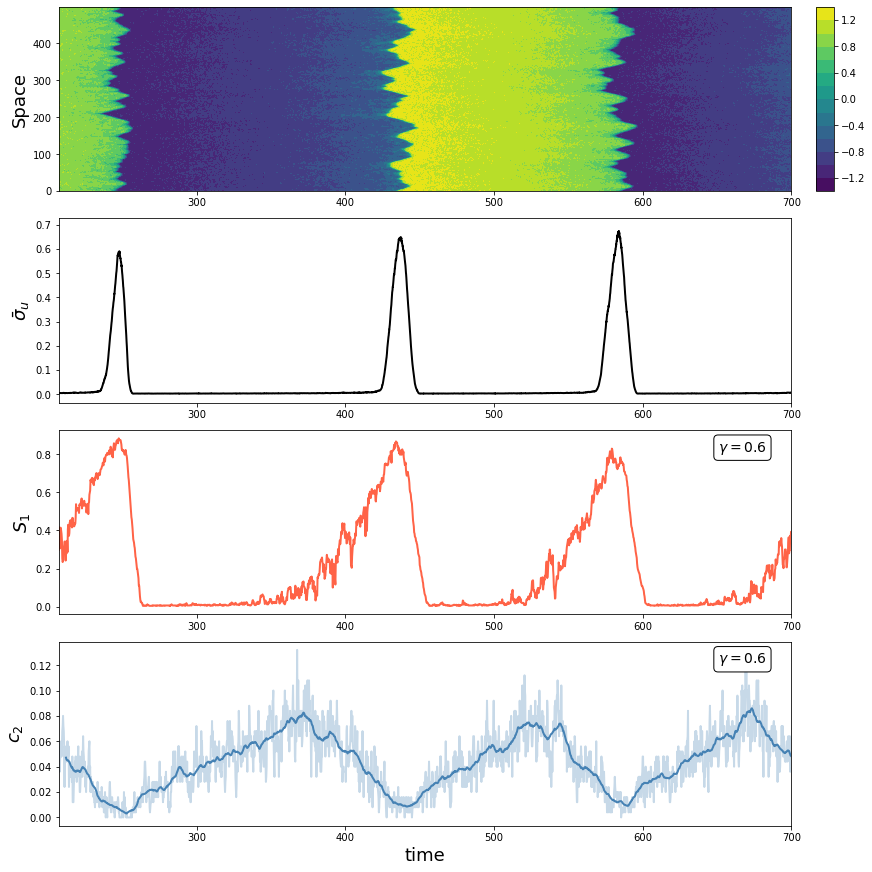

In [47]:
fig = plt.figure(constrained_layout=True, figsize = (12,12))
gs = GridSpec(4, 2, figure=fig, width_ratios = [1, 0.025])

# create sub plots as grid
ax1 = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])



################ spatio-temporal evolution #########
yspace = np.array(range(Nx))
xt, ys = np.meshgrid(tt_PHI,yspace)

im = ax1.contourf(xt, ys, PHI[0,:,:],15)
fig.colorbar(im, cax=cax)

ax1.set_ylabel('Space', fontsize=18)
ax1.set_xlim((init_i+num_t)*dt, dt*(final_i-num_t))

############### variance ##########################

ax2.plot(tt_PHI[:],var_s[:], color = 'black', linewidth = 2, alpha = 1)
ax2.set_ylabel(r'$\bar{\sigma}_u$', fontsize=18)
ax2.set_xlim((init_i+num_t)*dt, dt*(final_i-num_t))


############## S1 ##################################

#axs2 = axs[2].twinx()
ax3.plot(tt_measures[:],S1, color = 'tomato', linewidth = 2, alpha = 1)
ax3.set_ylabel(r'$S_1$', fontsize=18)
ax3.set_xlim((init_i+num_t)*dt, dt*(final_i-num_t))

props = dict(boxstyle='round', facecolor='white', alpha=1)
ax3.text(0.9, 0.95, r"$\gamma =$"+str(round(measures_nd["Gamma"][gidx_nd],3)), transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

############## c2 ##################################

ax4.plot(tt_measures[:],c2, color = 'steelblue', linewidth = 2, alpha = 0.3) # facecolors='none', edge
ax4.plot(tt_measures[bandwidth:-bandwidth+1],smoothed_c2[:], color = 'steelblue', linewidth = 2, alpha = 1)
ax4.set_ylabel(r'$c_2$', fontsize=18)
ax4.set_xlim((init_i+num_t)*dt, dt*(final_i-num_t))
ax4.set_xlabel('time', fontsize = 18)

props = dict(boxstyle='round', facecolor='white', alpha=1)
ax4.text(0.9, 0.95, r"$\gamma =$"+str(round(measures_nd["Gamma"][gidx_nd],3)), transform=ax4.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.savefig(folder_name+subfolder+'/non-detrended-percolation-measures.png', dpi=600, bbox_inches='tight')

### detrended data

In [59]:
# select the threshold value to plot time series for    
gidx_d = 3
print("Chosen threshold for plotting the non-detrended data: ",measures_d["Gamma"][gidx_d])
gamma_str_d = str(measures_d["Gamma"][gidx_d])
gamma_str_d = gamma_str_d.replace('.', 'p',1)

# time series of the percolation measures
S1d = measures_d["S1"][gidx_d]
c2d = measures_d["c2"][gidx_d]


# smooth the c2 curve for claritiy of the figure
bandwidth = 20
smoothed_c2d = []
for t in range(bandwidth, len(c2d)-bandwidth+1):
    smoothed_c2d.append(np.mean(c2d[t-bandwidth:t+bandwidth]))
smoothed_c2d = np.array(smoothed_c2d)


Chosen threshold for plotting the non-detrended data:  0.5133333333333333


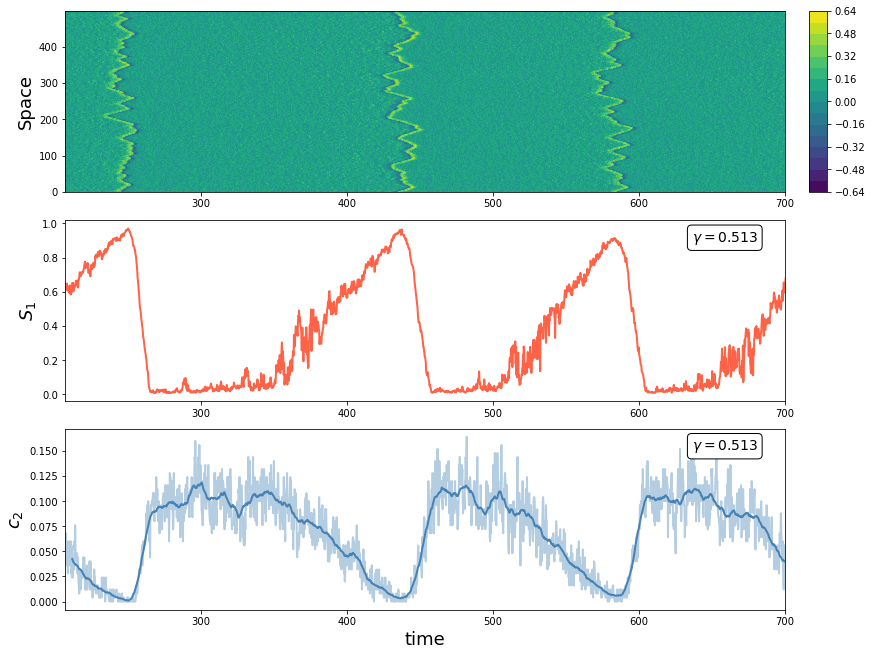

In [60]:
fig = plt.figure(constrained_layout=True, figsize = (12,9))
gs = GridSpec(3, 2, figure=fig, width_ratios = [1, 0.025])

# create sub plots as grid
ax1 = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])


################ spatio-temporal evolution #########
yspace = np.array(range(Nx))
xt, ys = np.meshgrid(tt_PHI,yspace)

im = ax1.contourf(xt, ys, PHI[0,:,:]-smoothed_u,15)
fig.colorbar(im, cax=cax)

ax1.set_ylabel('Space', fontsize=18)
ax1.set_xlim((init_i+num_t)*dt, dt*(final_i-num_t))

############## S1 ##################################

ax2.plot(tt_measures[:],S1d, color = 'tomato', linewidth = 2, alpha = 1)
ax2.set_ylabel(r'$S_1$', fontsize=18)
ax2.set_xlim((init_i+num_t)*dt, dt*(final_i-num_t))

    
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax2.text(0.87, 0.95, r"$\gamma =$"+str(round(Gammas_d[gidx_d],3)), transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

############## c2 ##################################
   
ax3.plot(tt_measures[:],c2d, color = 'steelblue', linewidth = 2, alpha = 0.4)
ax3.plot(tt_measures[bandwidth:-bandwidth+1],smoothed_c2d[:], color = 'steelblue', linewidth = 2, alpha = 1)
ax3.set_ylabel(r'$c_2$', fontsize=18)
ax3.set_xlim((init_i+num_t)*dt, dt*(final_i-num_t))
ax3.set_xlabel('time', fontsize = 18)

    
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax3.text(0.87, 0.95, r"$\gamma =$"+str(round(Gammas_d[gidx_d],3)), transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig(folder_name+subfolder+'/detrended-percolation-measures.png', dpi=600, bbox_inches='tight')